<a href="https://colab.research.google.com/github/jackysiupuichung/gait_analysis_basketball_shooting/blob/main/shooting_analysis_opencv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mediapipe 

In [2]:
import cv2
import time
import math as m
import mediapipe as mp
import numpy as np

In [3]:
#Function to calculate offset distance for proper side view by measuring hip points, the eyes, or the shoulder
def findDistance(x1, y1, x2, y2):
  dist = m.sqrt((x2-x1)**2+(y2-y1)**2)
  return dist

In [4]:
# Calculate angle between three points
def findAngle(a, b, c):
    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)

    return np.degrees(angle)

In [5]:
import cv2
import mediapipe as mp
from google.colab.patches import cv2_imshow
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

In [80]:
cap = cv2.VideoCapture('shooting_short_Trim.mp4')
lm_timeseries = []
lmPose_timeseries  = []
with mp_pose.Pose(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as pose:
  idx = 0
  while cap.isOpened():
    success, image = cap.read()
    if not success:
      print("Ignoring empty camera frame.")
      # If loading a video, use 'break' instead of 'continue'.
      break

    # To improve performance, optionally mark the image as not writeable to
    # pass by reference.
    image.flags.writeable = False
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image)
    lm_timeseries.append(results.pose_landmarks)
    lmPose_timeseries.append(mp_pose.PoseLandmark)
    # Draw the pose annotation on the image.
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    mp_drawing.draw_landmarks(
        image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
    
    # Flip the image horizontally for a selfie-view display.
    cv2.imwrite('/content/annotated_image/' + str(idx) + '.png', image)
    idx += 1
    if cv2.waitKey(5) & 0xFF == 27:
      break
cap.release()

Ignoring empty camera frame.


In [39]:
#convert annotated images into video
image_folder = '/content/annotated_image'
video_name = 'shooting_short_trim_annotated.mp4'

import cv2
import numpy as np
import glob

img_array = []
for filename in sorted(glob.glob('/content/annotated_image/*.png')):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)


out = cv2.VideoWriter(video_name,-1, 1, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [97]:
def gait_calculate_angle(lm, lmPose, landmarks, width, height):
    a_x = int(lm.landmark[lmPose(landmarks[0])].x * width)
    a_y = int(lm.landmark[lmPose(landmarks[0])].y * height)
    a = np.array([a_x, a_y])

    #left knee
    b_x = int(lm.landmark[lmPose(landmarks[1])].x * width)
    b_y = int(lm.landmark[lmPose(landmarks[1])].y * height)
    b = np.array([b_x, b_y])

    #left ankle
    c_x = int(lm.landmark[lmPose(landmarks[2])].x * width)
    c_y = int(lm.landmark[lmPose(landmarks[2])].y * height)
    c = np.array([c_x, c_y])

    return findAngle(a, b, c)

In [98]:
#triple extension landmarks
right_knee_angle_landmarks = [24, 26, 28]
left_knee_angle_landmarks = [23, 25, 27]

right_ankle_angle_landmarks = [26, 28, 32]
left_ankle_angle_landmarks = [25, 27, 31]

right_hip_angle_landmarks = [12, 24, 26]
left_hip_angle_landmarks = [11, 23, 25]

In [100]:
left_knee_angle_timeseries = []
right_knee_angle_timeseries = []

left_ankle_angle_timeseries = []
right_ankle_angle_timeseries = []

left_hip_angle_timeseries = []
right_hip_angle_timeseries = []

for lm, lmPose in zip(lm_timeseries, lmPose_timeseries):
    #left hip
    if lm and lmPose == np.NaN:
        continue
    else:
        right_knee_angle_timeseries.append(gait_calculate_angle(
            lm, lmPose, right_knee_angle_landmarks, width, height))
        right_ankle_angle_timeseries.append(gait_calculate_angle(
            lm, lmPose, right_ankle_angle_landmarks, width, height))
        right_hip_angle_timeseries.append(gait_calculate_angle(
            lm, lmPose, right_hip_angle_landmarks, width, height))
        
        left_knee_angle_timeseries.append(gait_calculate_angle(
            lm, lmPose, left_knee_angle_landmarks, width, height))
        left_ankle_angle_timeseries.append(gait_calculate_angle(
            lm, lmPose, left_ankle_angle_landmarks, width, height))
        left_hip_angle_timeseries.append(gait_calculate_angle(
            lm, lmPose, left_hip_angle_landmarks, width, height))

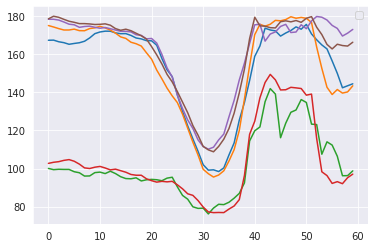

In [103]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style("darkgrid")
plt.plot(left_knee_angle_timeseries)
plt.plot(right_knee_angle_timeseries)
plt.plot(left_ankle_angle_timeseries)
plt.plot(right_ankle_angle_timeseries)
plt.plot(left_hip_angle_timeseries)
plt.plot(right_hip_angle_timeseries)
plt.show()

TODO: what parameters to measure
      elbow angle change
      shoulder angle change
      wrist angle change

optional features: frontal (elbow aligned)

Research objective:
      triple extension achieved?
      identify features by timing
          elbow push upwards?
          distance between elbow and core body
          hands quick leg slow
      compare against another person
